#**BBQ-mIS**
Graph coloring optimization on neutral atoms quantum machines.
* clone repository (codes building blocks and graphs dataset)
* install needed libraries
* investigate BB behaviour by changing 
  * exploration policy, i.e. queue_strategy (https://pybnb.readthedocs.io/en/stable/index.html)
  * feasible coloring computation
  * maximum number of explored nodes

In [1]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

Cloning into 'Master-QCC-2022-2023'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 43 (delta 16), reused 37 (delta 13), pack-reused 0
Unpacking objects: 100% (43/43), 17.66 KiB | 1.10 MiB/s, done.


In [2]:
!pip install pulser==0.7
!pip install pybnb
!pip install networkx==2.5.1
!pip install mpi4py

  Using cached pulser-0.7.0-py3-none-any.whl (6.8 kB)
  Using cached pulser_core-0.7.0-py3-none-any.whl (108 kB)
  Using cached pulser_simulation-0.7.0-py3-none-any.whl (26 kB)
  Using cached jsonschema-4.4.0-py3-none-any.whl (72 kB)
  Using cached pybnb-0.6.2.tar.gz (92 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Created wheel for pybnb: filename=pybnb-0.6.2-py2.py3-none-any.whl size=60620 sha256=43d4fa2d981649a80af33fc6ba545c6254a0c52ee8b54ca5d38cd8633926fa2a
  Stored in directory: c:\users\chiaravercellino\appdata\local\pip\cache\wheels\e4\00\10\d3f482061807e286001f598b8e20139454a7482912996871e5
Successfully built pybnb
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Attempting uninstall: networkx
    Found existing install

In [3]:
%cd /content/Master-QCC-2022-2023/

/content/Master-QCC-2022-2023


In [10]:
def compute_obj(G, colors_used, previous_coloring):
    if len(G.edges())>0:
        obj = colors_used+len(G.nodes())
        for greedy_color_node in G.nodes():
            colors_used = colors_used + 1
            previous_coloring[greedy_color_node] = colors_used
    else:
        for node in G.nodes():
            previous_coloring[node]=colors_used+1
        obj = colors_used+1
    return obj, previous_coloring

In [2]:
import pybnb
import numpy as np
from src.graph_coloring.BB_utils import *
from src.graph_coloring.MIS import PulserMISSolver
from src.graph_coloring.feasibility_utils import is_mIS

class BBQ_mIS(pybnb.Problem):
    
    def __init__(self, G, colors_used=0):
        self.G = G 
        self.orig_G = G.copy()     
        self.x = np.zeros((len(G.nodes),1))
        _, LB, _ = compute_LB(self.x, self.G)
        self.colors_used = colors_used
        self.edges = len(G.edges())
        self.fingerprints=set([])        
        self.lower_bound=colors_used+LB
        coloring =  dict.fromkeys(G.nodes(), -1)
        obj, coloring = compute_obj(G, colors_used, coloring)
        self.obj = obj
        self.coloring = coloring
        self.child_story={0:-1}
        self.hist_list = []
        self.solutions = None

    def sense(self):
        return pybnb.minimize

    def objective(self):             
        return self.obj

    def bound(self):
        # lower bound on the objective function
        return self.lower_bound

    def save_state(self, node, x=None, colors_used=None, lower_bound=None, H=None, obj=None, coloring=None, child_story=None, solutions = None, hist_list=None):
        if x is None:
            # root node initialization
            node.state = (self.x, self.colors_used, self.G, self.edges, self.coloring, self.child_story, self.solutions, self.hist_list)
        else:
            num_edges = len(H.edges())
            node.state = (x, colors_used, H, num_edges, coloring, child_story, solutions, hist_list)
            node.objective = obj
            node.bound = lower_bound
            UB = compute_UB(H)
            node.queue_priority = -UB*num_edges
                          
            
    def load_state(self, node):
        (self.x, self.colors_used, self.G, self.edges, self.coloring, self.child_story, self.solutions, self.hist_list) = node.state
        self.obj = node.objective
        self.lower_bound = node.bound

    def branch(self):
        pulser_MIS_solver = PulserMISSolver(self.G)
        pulser_sol = pulser_MIS_solver.solve_Pulser()
        hist_list=self.hist_list.copy()
        hist_list.append(pulser_sol)
        num_colors_child = self.colors_used+1
        solutions = []  
        for sol in pulser_sol:
            solutions.append(np.array(list(sol[0]), dtype=int))
        num_sol = len(solutions)
        child_num=0                    
        for sol in range(num_sol): 
            child_story=self.child_story.copy()
            child_story[num_colors_child]=child_num+1
            coloring_dict = self.coloring.copy() 
            x = solutions[sol]      
            if is_mIS(x, self.G):                                
                H, LB, MIS_set = compute_LB(x, self.G)
                for graph_node in MIS_set:
                    coloring_dict[graph_node]=num_colors_child                
                fp = fingerprint(H.nodes())                
                if fp not in self.fingerprints and len(H.nodes())>0:
                    child_num+=1
                    # avoid symmetries in BB
                    child = pybnb.Node()
                    obj, coloring_dict = compute_obj(H, num_colors_child, coloring_dict)
                    child_bound = num_colors_child+LB
                    self.save_state(child, x, num_colors_child, child_bound, H, obj, coloring_dict, child_story, pulser_sol, hist_list)
                    self.fingerprints.add(fp)
                    yield child


Using non-default solver options:
 - node_limit: 20 (default: None)
 - queue_strategy: custom (default: bound)

Starting branch & bound solve:
 - dispatcher pid: 15572 (LAPTOP-SIDQI55K)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
         1         5  |            inf               3         inf%             inf |     16.1       0.06     0.00%      0
*        2         2  |              4               3   25.000000%               1 |     24.7       0.11     0.00%      0
         3         1  |              4               3   

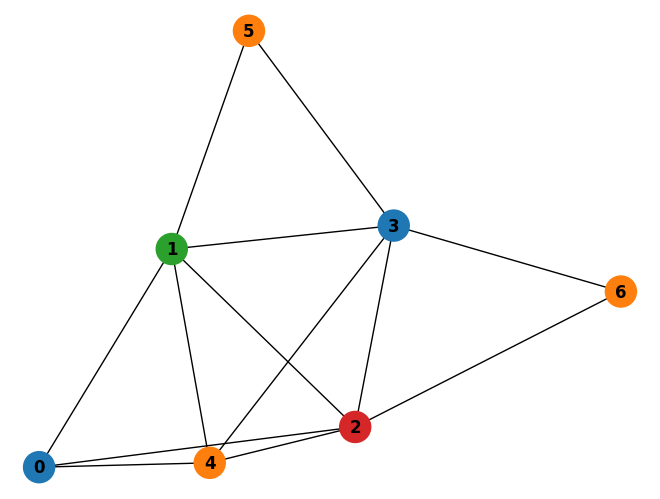

Best solution history:
	 Step 1 -> selected MIS solution at position 5

Step 1 -> nodes in MIS solution [0, 3]
Step 2 -> nodes in MIS solution [4, 5, 6]
Step 3 -> nodes in MIS solution [1]
Step 4 -> nodes in MIS solution [2]
Coloring story {0: -1, 1: 5}
BBQ-mIS found coloring with 4 colors


In [3]:
import networkx as nx
from src.graph_coloring.BB_utils import *

file_path="graphs/{}G_{}ud.gpickle".format(7, 2)
G = nx.read_gpickle(file_path)
max_nodes=20
problem = BBQ_mIS(G)
solver = pybnb.Solver()
results = solver.solve(problem, queue_strategy='custom', node_limit=max_nodes)
best_coloring = results.best_node.state[4]
child_story = results.best_node.state[5]
plot_sol(G, best_coloring, results.objective)    
print_BB_history(child_story)
# print the MISs for the best solution
print_mIS(best_coloring)
print('Coloring story {}'.format(child_story))
print('BBQ-mIS found coloring with {} colors'.format(results.objective))